In [1]:
# !pip install keras-core --upgrade
# !pip install -q keras-nlp
# !pip install seaborn

In [21]:
# !pip install transformers

# Import the Libararies

In [3]:
# !pip install pandas

In [22]:
# !pip install tqdm

In [1]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# import tensorflow as tf
# import keras_core as keras
# import keras_nlp
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
# print("TensorFlow version:", tf.__version__)
import re
from tqdm.auto import tqdm
tqdm.pandas()
from tqdm import tqdm
# from sentence_transformers import SentenceTransformer
# from scipy.spatial.distance import cosine
import random
# print("Keras version:", keras.__version__)
# print("KerasNLP version:", keras_nlp.__version__)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Load the data


In [3]:
train_prompts = pd.read_csv ('/kaggle/input/llm-detect-ai-generated-text/train_prompts.csv')  #('train_prompts.csv')
train_essays = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/train_essays.csv')  #('train_essays.csv')
test_essays = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/test_essays.csv')  #('test_essays.csv')
train_extra = pd.read_csv('/kaggle/input/daigt-v3-train-dataset/train_v3_drcat_01.csv')  #('train_v3_drcat_01.csv')
train_extra_2 = pd.read_csv('/kaggle/input/daigt-v3-train-dataset/train_v3_drcat_02.csv')  #('train_v3_drcat_02.csv')
cleaned_text_3 = pd.read_csv('/kaggle/input/clean-data-set/cleaned_data_3_clean.csv')

# 🐝데이터 준비 (train+extra)

Text(0.5, 1.0, 'Distribution of Generated Text')

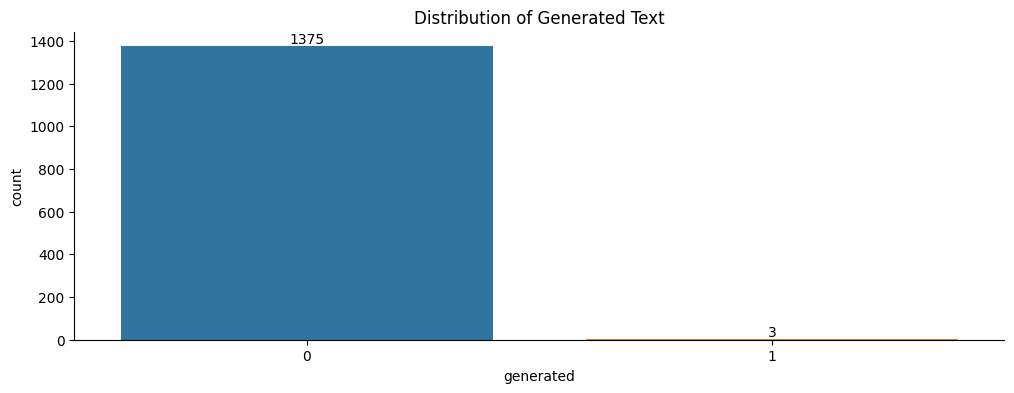

In [4]:
f, ax = plt.subplots(figsize=(12, 4))

sns.despine()
ax = sns.countplot(data=train_essays,
                   x="generated")

abs_values = train_essays['generated'].value_counts().values

ax.bar_label(container=ax.containers[0], labels=abs_values)

ax.set_title("Distribution of Generated Text")

In [5]:
train_essays['text_length'] = train_essays['text'].apply(len)
train_essays.drop(['id','prompt_id'],axis=1,inplace=True)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


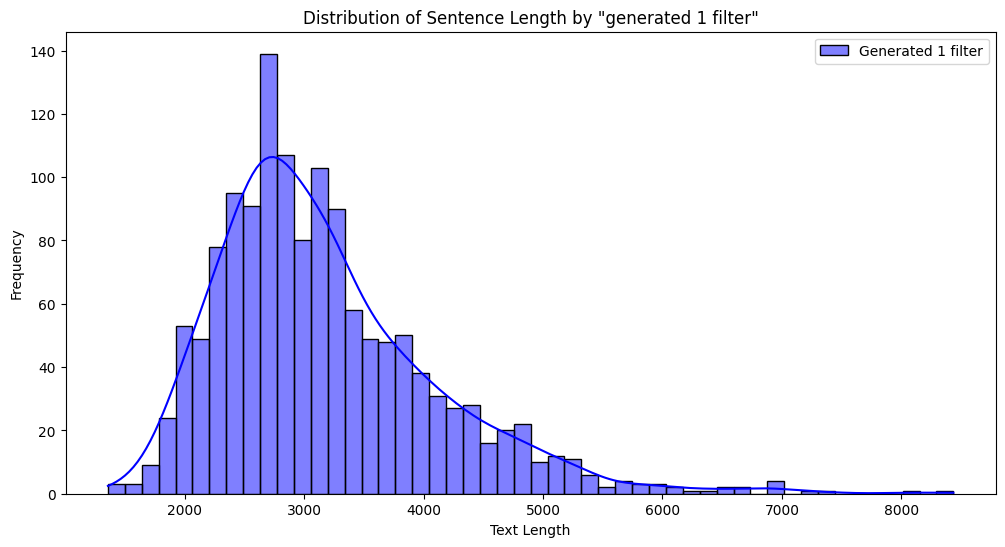

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
# Plotting the histogram
plt.figure(figsize=(12, 6))
sns.histplot(train_essays['text_length'], bins=50, color='blue', label='Generated 1 filter', kde=True)
plt.title('Distribution of Sentence Length by "generated 1 filter"')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [7]:
train_essays = train_essays.loc[(train_essays['text_length'] >= 746) & (train_essays['text_length'] <= 6000)]

In [8]:
train_essays.head()

,text,generated,text_length
0,Cars. Cars have been around since they became ...,0,3289
1,Transportation is a large necessity in most co...,0,2738
2,"""America's love affair with it's vehicles seem...",0,4428
3,How often do you ride in a car? Do you drive a...,0,4013
4,Cars are a wonderful thing. They are perhaps o...,0,4698


In [9]:
train_essays.describe()

,generated,text_length
count,1362.000000,1362.000000
mean,0.002203,3125.391336
std,0.046898,829.878047
min,0.000000,1356.000000
25%,0.000000,2550.250000
50%,0.000000,2977.500000
75%,0.000000,3596.750000
max,1.000000,5977.000000


In [10]:
train_essays.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1362 entries, 0 to 1377
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   text         1362 non-null   object
 1   generated    1362 non-null   int64 
 2   text_length  1362 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 42.6+ KB


# ====== train_extra로부터 데이터 증강 ==========

In [14]:
df_train_extra=pd.concat([train_extra,train_extra_2],ignore_index=True)

df_train_extra.rename(columns = {"label":"generated"}, inplace=True)

In [15]:
unique_prompt_names = df_train_extra['prompt_name'].unique()
print(unique_prompt_names)

['Phones and driving' 'Car-free cities' 'Summer projects'

 '"A Cowboy Who Rode the Waves"' 'Mandatory extracurricular activities'

 'Exploring Venus' 'Facial action coding system' 'The Face on Mars'

 'Community service' 'Grades for extracurricular activities'

 'Driverless cars' 'Does the electoral college work?'

 'Cell phones at school' 'Distance learning' 'Seeking multiple opinions']


In [16]:
# generated 열 값이 0인 행들만 추출하여 새로운 데이터프레임 생성
df_train_extra_stu1 = df_train_extra[df_train_extra['generated'] == 1]
df_train_extra_stu0 = df_train_extra[df_train_extra['generated'] == 0]
# df_train_extra_stu = df_train_extra_stu.drop(columns=["prompt_name", "RDizzl3_seven", 'model'])

# df_train_extra_stu = df_train_extra_stu[df_train_extra_stu['source'] == 'train_essays']

# 새로운 데이터프레임 확인
print(df_train_extra_stu1)
print(df_train_extra_stu0)

                                                     text  generated  \

25996    In recent years, technology has had a profoun...          1   

25997   I strongly believe that meditation and mindful...          1   

25998   One way school administrators can attempt to c...          1   

25999   While summer is meant as a break from the regu...          1   

26000   The use of Facial Action Coding System (FACS) ...          1   

...                                                   ...        ...   

130770  Dear Senator,\n\nI am writing to you regarding...          1   

130771  I remember the day distinctively. I was sittin...          1   

130772  Dear Senator, \n\nI am writing this letter to ...          1   

130773  Dear Senator,\n\nI am writing to urge you to e...          1   

130774  It was a typical summer afternoon in my hometo...          1   



                             prompt_name                source  RDizzl3_seven  \

25996                    Car-free cities

In [17]:
df_train_extra_stu = pd.concat([df_train_extra_stu0,df_train_extra_stu1])

In [18]:
# 공백 제거
df_train_extra_stu.dropna(subset=['text'], inplace=True)
df_train_extra_stu['text'] = df_train_extra_stu['text'].str.strip()
df_train_extra_stu = df_train_extra_stu[df_train_extra_stu['text'] != ""]

# 중복된 텍스트 제거
df_train_extra_stu.drop_duplicates(subset='text', keep='first', inplace=True)

In [19]:
import re

# 공백 제거
df_train_extra_stu.dropna(subset=['text'], inplace=True)
df_train_extra_stu['text'] = df_train_extra_stu['text'].str.strip()
df_train_extra_stu = df_train_extra_stu[df_train_extra_stu['text'] != ""]

def clean_text(text):
    # 줄넘김 기호를 공백으로 대체
    text = re.sub(r'[\r\n]', ' ', text)
    # 연속된 마침표 제거 (단, 단일 마침표는 유지)
    text = re.sub(r'\.{2,}', '', text)
        # 연속된 물음표와 느낌표를 하나로 축소
    text = re.sub(r'\?{2,}', '?', text)
    text = re.sub(r'!{2,}', '!', text)
    # 특수 문자 제거 (단, 영문자, 숫자, 밑줄, 공백, 단일 마침표, 물음표, 느낌표는 유지)
    text = re.sub(r'[^\w\s.?!]', '', text)
    
#     # 연속되는 동일한 단어 또는 구문 제거 (예: 'I I I I...' 또는 'Claim The Face...')
#     text = re.sub(r'(\b\w+\b)( \1\b)+', r'\1', text)
    return text

def is_text_too_short(text, min_length=150):
    # 텍스트 길이가 최소 길이보다 짧은지 확인
    return len(text) > min_length

# DataFrame의 'text' 컬럼에 clean_text 함수 적용
df_train_extra_stu['text'] = df_train_extra_stu['text'].progress_apply(clean_text)

# 너무 짧은 텍스트 필터링
df_train_extra_stu = df_train_extra_stu[df_train_extra_stu['text'].progress_apply(is_text_too_short)]


# 중복된 텍스트 제거
df_train_extra_stu.drop_duplicates(subset='text', keep='first', inplace=True)


def has_repeated_sentences(text):
    # 단어 또는 구문의 반복을 체크하는 함수
    # '\b'는 단어 경계를 나타냄, '(.+)'는 임의의 문자열, '\s'는 공백, '\1'은 첫번째 캡쳐된 그룹
    if re.search(r'(\b.+)\b\s+\1', text):
        return True
    return False

# 'text' 컬럼에서 반복되는 문장을 포함하는 행을 필터링하고 제거
df_train_extra_stu = df_train_extra_stu[df_train_extra_stu['text'].progress_apply(has_repeated_sentences)]



  0%|          | 0/75006 [00:00<?, ?it/s]

  0%|          | 0/75006 [00:00<?, ?it/s]

  0%|          | 0/70571 [00:00<?, ?it/s]

In [22]:
df_train_extra_stu['text_length'] = df_train_extra_stu['text'].apply(lambda x: len(str(x)))
df_train_extra_stu=df_train_extra_stu.drop(['prompt_name','source','RDizzl3_seven','model'],axis=1)

In [23]:
# 'text' 열을 문자열로 캐스팅하고 리스트로 변환
df_train_extra_stu_sen = df_train_extra_stu['text'].astype(str).tolist()

# 각 텍스트의 문장 수를 세어 새로운 열에 저장
df_train_extra_stu['sentence_count'] = [text.count('.') + text.count('!') + text.count('?') for text in df_train_extra_stu_sen]
# df_train_extra_stu.drop(['prompt_name','source','RDizzl3_seven','model'],axis=1,inplace=True)

In [24]:
df_train_extra_stu.tail()

,text,generated,text_length,sentence_count
130710,Dear Senator I am writing to you today to ex...,1,1984,16
130743,Dear Senator I am writing to support the con...,1,1825,14
130756,Dear Senator I am writing to you today beca...,1,2505,21
130759,Dear Senator Im writing to urge you to take a ...,1,2256,20
130763,Dear Senator I am writing to you today to exp...,1,2496,18


Text(0.5, 1.0, 'Distribution of Generated Text')

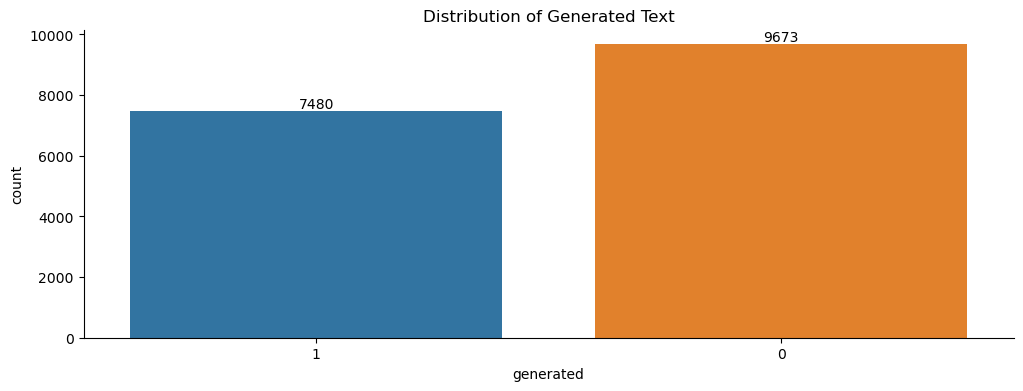

In [25]:
f, ax = plt.subplots(figsize=(12, 4))

sns.despine()
ax = sns.countplot(data=df_train_extra_stu,
                   x="generated",
                   order=df_train_extra_stu['generated'].value_counts().index[::-1])  # 데이터를 뒤집어서 정렬

abs_values = df_train_extra_stu['generated'].value_counts().values[::-1]  # 데이터를 뒤집어서 정렬

ax.bar_label(container=ax.containers[0], labels=abs_values)

ax.set_title("Distribution of Generated Text")


Text(0.5, 1.0, 'Distribution of Generated Text')

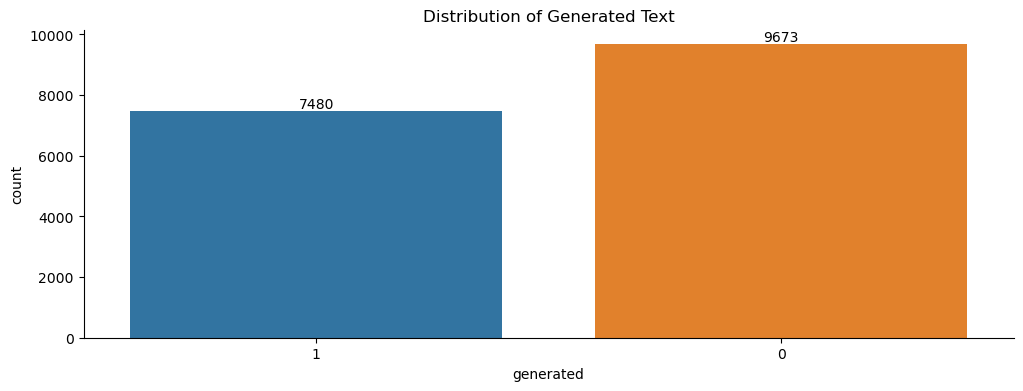

In [26]:
f, ax = plt.subplots(figsize=(12, 4))

sns.despine()
ax = sns.countplot(data=df_train_extra_stu,
                   x="generated",
                   order=df_train_extra_stu['generated'].value_counts().index[::-1])  # 데이터를 뒤집어서 정렬

abs_values = df_train_extra_stu['generated'].value_counts().values[::-1]  # 데이터를 뒤집어서 정렬

ax.bar_label(container=ax.containers[0], labels=abs_values)

ax.set_title("Distribution of Generated Text")


In [27]:
selected_rows1 = df_train_extra_stu[df_train_extra_stu['generated'] == 1]
selected_rows0 = df_train_extra_stu[df_train_extra_stu['generated'] == 0]
# 선택된 행들에 대해 describe를 수행합니다.
description1 = selected_rows1.describe()
description0 = selected_rows0.describe()

# 결과를 출력합니다.
print(description0)
print(description1)

       generated  text_length  sentence_count

count     9673.0  9673.000000     9673.000000

mean         0.0  2609.458803       23.356456

std          0.0  1175.333062       10.770219

min          0.0   742.000000        0.000000

25%          0.0  1710.000000       16.000000

50%          0.0  2408.000000       22.000000

75%          0.0  3252.000000       29.000000

max          0.0  9074.000000      135.000000

       generated  text_length  sentence_count

count     7480.0  7480.000000     7480.000000

mean         1.0  2654.730080       21.646257

std          0.0  1145.908431        8.339677

min          1.0   242.000000        0.000000

25%          1.0  1849.000000       16.000000

50%          1.0  2411.000000       21.000000

75%          1.0  3229.000000       26.000000

max          1.0  8098.000000      100.000000


Text(0.5, 1.0, 'Distribution of Generated Text')

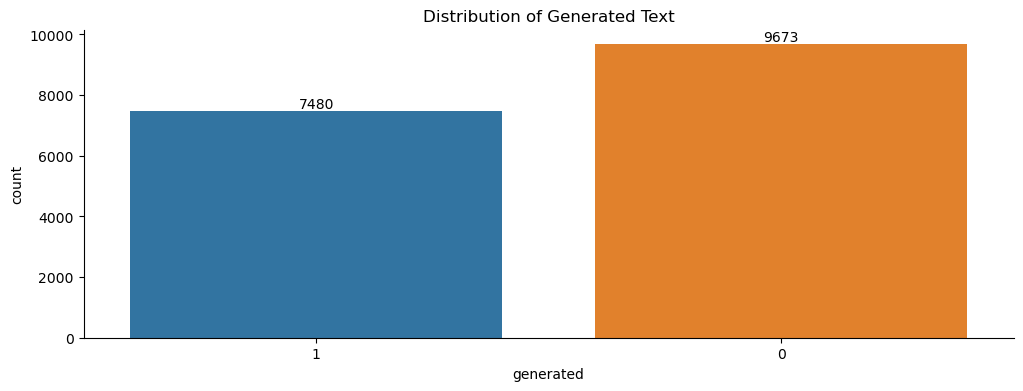

In [28]:
f, ax = plt.subplots(figsize=(12, 4))

sns.despine()
ax = sns.countplot(data=df_train_extra_stu,
                   x="generated",
                   order=df_train_extra_stu['generated'].value_counts().index[::-1])  # 데이터를 뒤집어서 정렬

abs_values = df_train_extra_stu['generated'].value_counts().values[::-1]  # 데이터를 뒤집어서 정렬

ax.bar_label(container=ax.containers[0], labels=abs_values)

ax.set_title("Distribution of Generated Text")


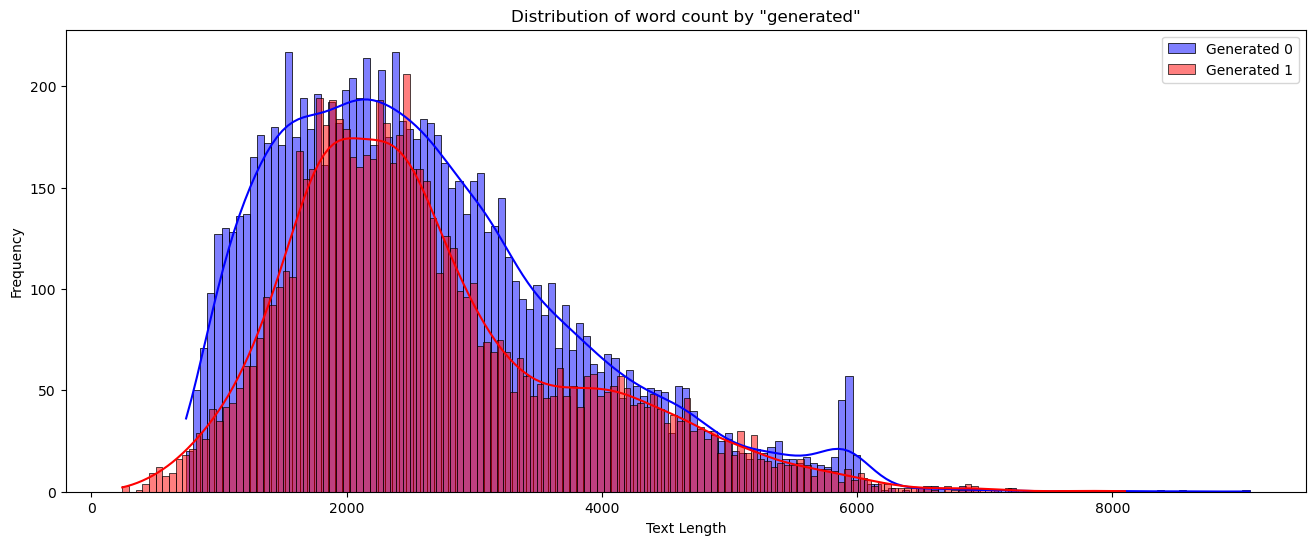

In [29]:
plt.figure(figsize=(16, 6))

# 'generated'가 0인 경우의 히스토그램
sns.histplot(df_train_extra_stu[df_train_extra_stu['generated'] == 0]['text_length'], bins=150, color='blue', label='Generated 0', kde=True)

# 'generated'가 1인 경우의 히스토그램
sns.histplot(df_train_extra_stu[df_train_extra_stu['generated'] == 1]['text_length'], bins=150, color='red', label='Generated 1', kde=True)

plt.title('Distribution of word count by "generated"')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.legend()
plt.show()


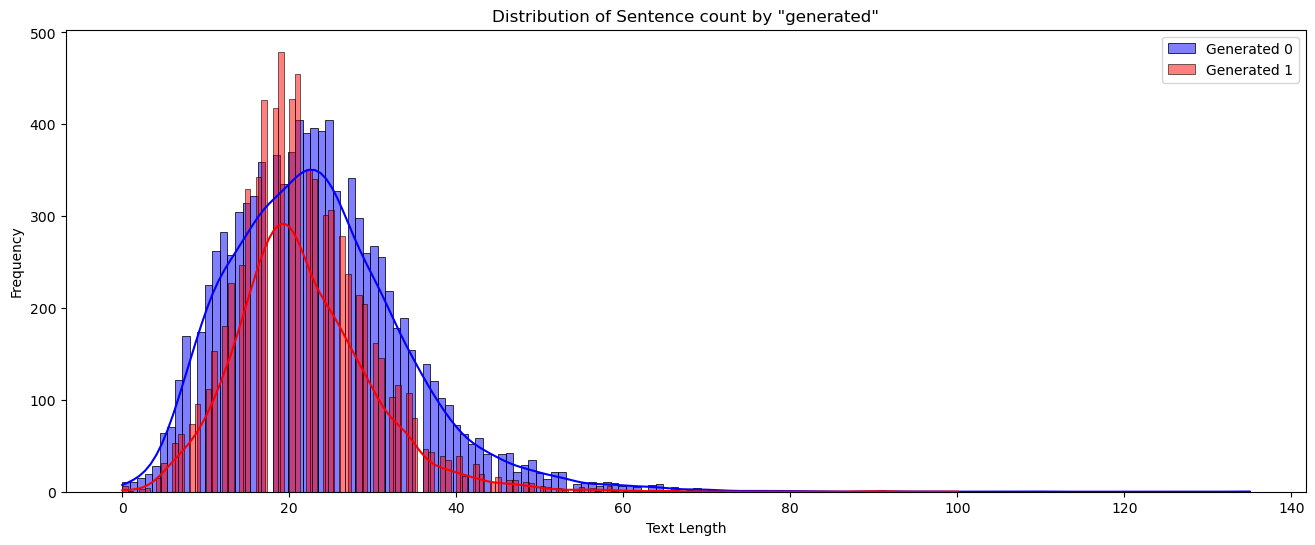

In [30]:
plt.figure(figsize=(16, 6))

# 'generated'가 0인 경우의 히스토그램
sns.histplot(df_train_extra_stu[df_train_extra_stu['generated'] == 0]['sentence_count'], bins=150, color='blue', label='Generated 0', kde=True)

# 'generated'가 1인 경우의 히스토그램
sns.histplot(df_train_extra_stu[df_train_extra_stu['generated'] == 1]['sentence_count'], bins=150, color='red', label='Generated 1', kde=True)

plt.title('Distribution of Sentence count by "generated"')
plt.xlabel('sentence_count')
plt.ylabel('Frequency')
plt.legend()
plt.show()


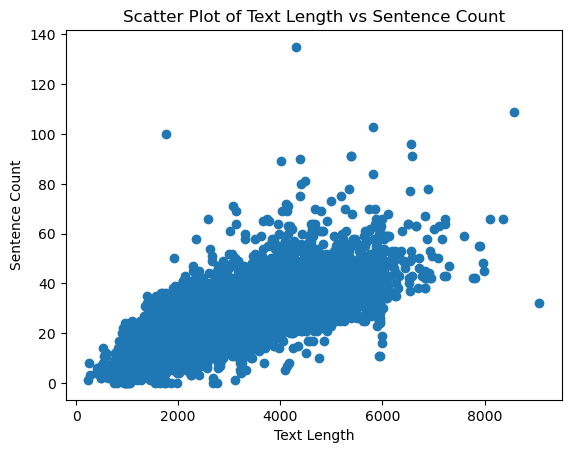

In [31]:
import matplotlib.pyplot as plt
import pandas as pd

# 데이터프레임 예시 (df_train_extra_stu)
# df_train_extra_stu = pd.DataFrame({
#     'text_length': [100, 200, 300, 400],
#     'sentence_count': [10, 20, 30, 40]
# })

# 산점도 생성
plt.scatter(df_train_extra_stu['text_length'], df_train_extra_stu['sentence_count'])
plt.xlabel('Text Length')
plt.ylabel('Sentence Count')
plt.title('Scatter Plot of Text Length vs Sentence Count')
plt.show()


In [32]:
# 상관계수 계산
correlation = df_train_extra_stu['text_length'].corr(df_train_extra_stu['sentence_count'])
print("Correlation coefficient:", correlation)


Correlation coefficient: 0.7796691742361674


In [33]:
selected_rows1 = df_train_extra_stu[df_train_extra_stu['generated'] == 1]
selected_rows0 = df_train_extra_stu[df_train_extra_stu['generated'] == 0]
# 선택된 행들에 대해 describe를 수행합니다.
description1 = selected_rows1.describe()
description0 = selected_rows0.describe()

# 결과를 출력합니다.
print(description0)
print(description1)

       generated  text_length  sentence_count

count     9673.0  9673.000000     9673.000000

mean         0.0  2609.458803       23.356456

std          0.0  1175.333062       10.770219

min          0.0   742.000000        0.000000

25%          0.0  1710.000000       16.000000

50%          0.0  2408.000000       22.000000

75%          0.0  3252.000000       29.000000

max          0.0  9074.000000      135.000000

       generated  text_length  sentence_count

count     7480.0  7480.000000     7480.000000

mean         1.0  2654.730080       21.646257

std          0.0  1145.908431        8.339677

min          1.0   242.000000        0.000000

25%          1.0  1849.000000       16.000000

50%          1.0  2411.000000       21.000000

75%          1.0  3229.000000       26.000000

max          1.0  8098.000000      100.000000


In [34]:
# 'generated' 열 값이 0인 경우와 1인 경우를 분리
generated_0_counts = df_train_extra_stu[df_train_extra_stu['generated'] == 0]['sentence_count'].value_counts().reset_index()
generated_0_counts.columns = ['sentence_count', 'generated_0_count']

generated_1_counts = df_train_extra_stu[df_train_extra_stu['generated'] == 1]['sentence_count'].value_counts().reset_index()
generated_1_counts.columns = ['sentence_count', 'generated_1_count']

# 결과를 오름차순으로 정렬
generated_0_counts = generated_0_counts.sort_values(by='sentence_count')
generated_1_counts = generated_1_counts.sort_values(by='sentence_count')

# 출력
print("Generated 0:")
print(generated_0_counts)

print("\nGenerated 1:")
print(generated_1_counts)


Generated 0:

    sentence_count  generated_0_count

53               0                 11

55               1                 11

50               2                 15

49               3                 19

44               4                 28

..             ...                ...

81              91                  1

73              96                  1

76             103                  1

77             109                  1

75             135                  1



[86 rows x 2 columns]



Generated 1:

    sentence_count  generated_1_count

46               0                  6

65               1                  1

54               2                  3

52               3                  4

40               4                 15

..             ...                ...

57              66                  2

62              70                  1

69              89                  1

58              91                  2

68             100                  1



[70 row

In [49]:
for index, row in df_train_extra_stu[(df_train_extra_stu['generated'] == 1) & (df_train_extra_stu['sentence_count'] == 3)].iterrows():
    print(row['text'])
    print("-" * 40)  # 경계선 출력

Introduction  For many students the idea of committing to a career can seem daunting and intimidating. However in todays everchanging and competitive job market committing to a career at a young age can be beneficial in more than one way. In this essay we will discuss the pros and cons of students starting their career at a young age provide examples to illustrate the advantages of deciding on a career early and explain why some people may disagree with decisions to embark on a career in high school.

----------------------------------------

The advantages of limiting car usage are that they include the following in at least a minimum level  Reduce potential for addiction to drugs or alcohol Reduce risk of being involved in a crash that leads to injury or a Cumbo Reduce risk of being a victim of a crash that Results in injury or a Cumbo Reduce risk of being a victim of a crash that leads to injury or a injury that is not wouldbe cornfield. Reduce risk of being a victim of a crash that

In [36]:
# 정제된 데이터를 CSV 파일로 저장
df_train_extra_stu.to_csv('cleaned_data_3.csv', index=False)

In [11]:
df_train_extra_stu = pd.read_csv('/kaggle/input/clean-data-set/cleaned_data_3_clean.csv')

# =====df_train_essays_final 데이터셋 준비=======

In [14]:
df_train_essays_final = pd.concat([train_essays,df_train_extra_stu],axis=0)

Text(0.5, 1.0, 'Distribution of Generated Text')

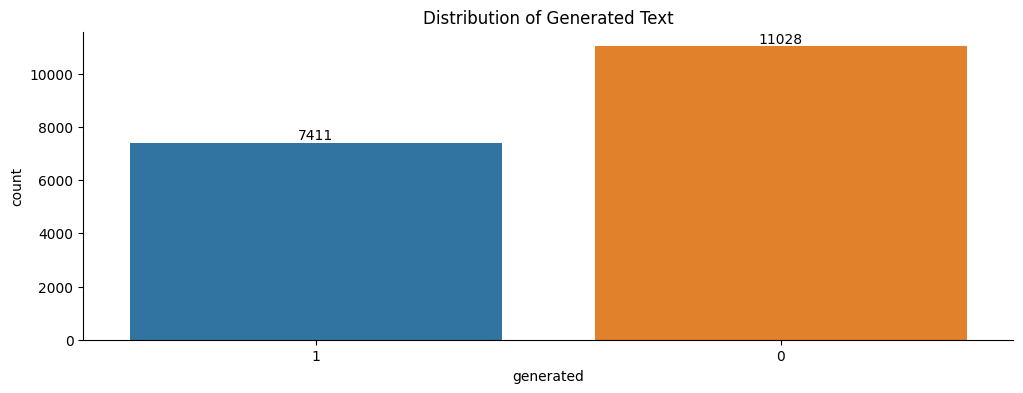

In [15]:
f, ax = plt.subplots(figsize=(12, 4))

sns.despine()
ax = sns.countplot(data=df_train_essays_final,
                   x="generated",
                   order=df_train_essays_final['generated'].value_counts().index[::-1])  # 데이터를 뒤집어서 정렬

abs_values = df_train_essays_final['generated'].value_counts().values[::-1]  # 데이터를 뒤집어서 정렬

ax.bar_label(container=ax.containers[0], labels=abs_values)

ax.set_title("Distribution of Generated Text")


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


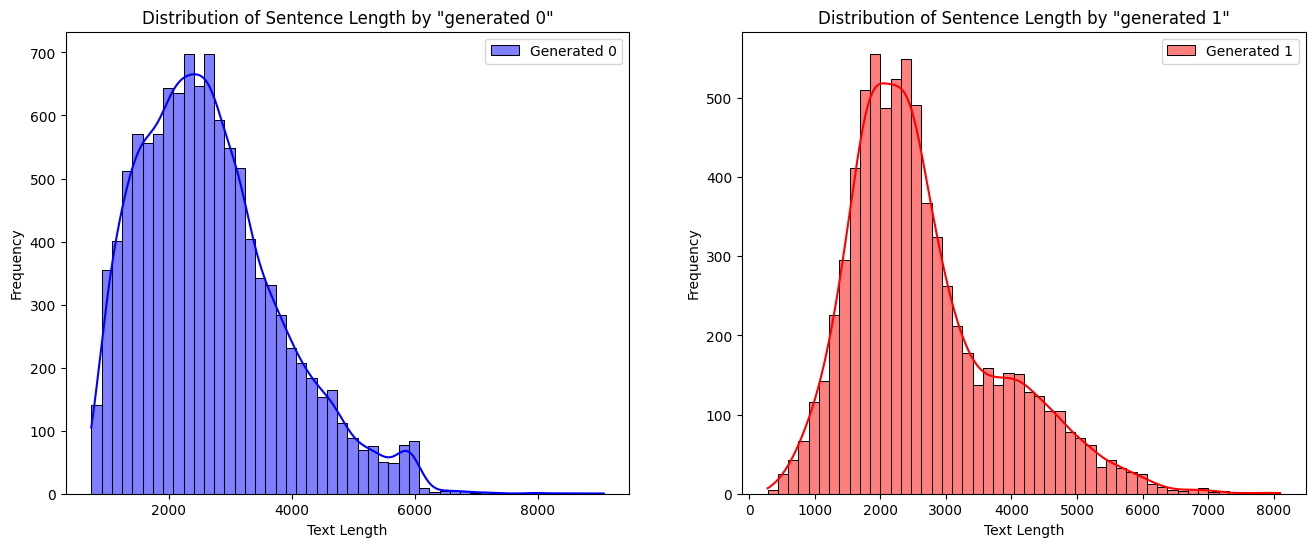

In [16]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot the histogram for 'text_length' with generated=0
sns.histplot(df_train_essays_final[df_train_essays_final['generated'] == 0]['text_length'], bins=50, color='blue', label='Generated 0', kde=True, ax=ax1)
ax1.set_title('Distribution of Sentence Length by "generated 0"')
ax1.set_xlabel('Text Length')
ax1.set_ylabel('Frequency')
ax1.legend()

# Plot the histogram for 'text_length' with generated=1
sns.histplot(df_train_essays_final[df_train_essays_final['generated'] == 1]['text_length'], bins=50, color='red', label='Generated 1', kde=True, ax=ax2)
ax2.set_title('Distribution of Sentence Length by "generated 1"')
ax2.set_xlabel('Text Length')
ax2.set_ylabel('Frequency')
ax2.legend()

plt.show()


In [18]:
df_train_essays_final = df_train_essays_final.drop(['text_length', 'sentence_count'],axis=1)

KeyError: "['text_length', 'sentence_count'] not found in axis"

In [ ]:
df_train_essays_final.head()

In [ ]:
df_train_essays_final.info()

# 🐝 **토큰화 진행 (WordPiece vs BPE)** 

## BPE

In [17]:
# max_length 파라미터 조정을 통한 성능 확인

In [18]:
problematic_data = df_train_essays_final[df_train_essays_final['text'].apply(lambda x: not isinstance(x, str))]
print(problematic_data)

Empty DataFrame

Columns: [text, generated]

Index: []


In [24]:
from tokenizers import(
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer,
)
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import Whitespace

from transformers import PreTrainedTokenizerFast

from datasets import Dataset
from tqdm.auto import tqdm
from tokenizers import processors

In [25]:
LOWERCASE = False
VOCAB_SIZE = 30522

In [26]:
# Tokenizer 초기화
raw_tokenizer = Tokenizer(models.BPE(unk_token="[UNK]"))

# Normalizer 설정
raw_tokenizer.normalizer = normalizers.Sequence([normalizers.NFC()] + [normalizers.Lowercase()] if LOWERCASE else [])

# Pre-tokenizer 설정: Byte-Level pre-tokenizer를 사용
# "Ġ" 문자 제거 하고 싶다면 -> add_prefix_space=False 추가
raw_tokenizer.pre_tokenizer = pre_tokenizers.ByteLevel()

# BPE Trainer 설정 및 스페셜 토큰 추가
special_tokens = ["[UNK]", "[PAD]", "[CLS]", "[SEP]", "[MASK]"]
trainer = trainers.BpeTrainer(vocab_size=VOCAB_SIZE, special_tokens=special_tokens)

# 데이터셋 로드 및 토크나이저 훈련 (훈련 셋 : df_train_essays_final[['text']])
dataset = Dataset.from_pandas(df_train_essays_final[['text']])
def train_corp_iter(): 
    for i in range(0, len(dataset), 1000):
        yield dataset[i : i + 1000]["text"]
raw_tokenizer.train_from_iterator(train_corp_iter(), trainer=trainer)

# PreTrainedTokenizerFast로 래핑
from transformers import RobertaTokenizerFast

tokenizer = PreTrainedTokenizerFast(
    tokenizer_object=raw_tokenizer,
    unk_token="[UNK]",
    pad_token="[PAD]",
    cls_token="[CLS]",
    sep_token="[SEP]",
    mask_token="[MASK]",
)

In [27]:
# "[UNK]" 토큰의 정수 ID 확인
unk_token_id = tokenizer.convert_tokens_to_ids("[UNK]")

# "[PAD]" 토큰의 정수 ID 확인
pad_token_id = tokenizer.convert_tokens_to_ids("[PAD]")

# "[CLS]" 토큰의 정수 ID 확인
cls_token_id = tokenizer.convert_tokens_to_ids("[CLS]")

# "[SEP]" 토큰의 정수 ID 확인
sep_token_id = tokenizer.convert_tokens_to_ids("[SEP]")

# "[MASK]" 토큰의 정수 ID 확인
mask_token_id = tokenizer.convert_tokens_to_ids("[MASK]")

print("[UNK] 토큰의 정수 ID:", unk_token_id)
print("[PAD] 토큰의 정수 ID:", pad_token_id)
print("[CLS] 토큰의 정수 ID:", cls_token_id)
print("[SEP] 토큰의 정수 ID:", sep_token_id)
print("[MASK] 토큰의 정수 ID:", mask_token_id)

[UNK] 토큰의 정수 ID: 0
[PAD] 토큰의 정수 ID: 1
[CLS] 토큰의 정수 ID: 2
[SEP] 토큰의 정수 ID: 3
[MASK] 토큰의 정수 ID: 4


In [28]:
text = ["Let's test this tokenizer.", "Nice to meet you"]
tokens = tokenizer.encode(text)
print(tokens)
print(tokenizer.decode(tokens))

[5457, 1364, 1504, 279, 21653, 442, 123, 11, 29654, 132, 1808, 181]
ĠLet's Ġtest Ġthis Ġtoken iz er. ĠNice Ġto Ġmeet Ġyou


In [29]:
tokens = tokenizer.tokenize(text)
print(tokens)

['ĠLet', "'s", 'Ġtest', 'Ġthis', 'Ġtoken', 'iz', 'er', '.', 'ĠNice', 'Ġto', 'Ġmeet', 'Ġyou']


In [30]:
encoding = tokenizer.encode_plus(text, return_tensors="tf")
print(encoding)

{'input_ids': <tf.Tensor: shape=(1, 12), dtype=int32, numpy=
array([[ 5457,  1364,  1504,   279, 21653,   442,   123,    11, 29654,
          132,  1808,   181]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(1, 12), dtype=int32, numpy=array([[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1, 12), dtype=int32, numpy=array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=int32)>}


In [32]:
# df_train_essays_final['text'] 토큰화 해보기
# test_essays 데이터의 토큰화 진행 상황을 표시
test_input_ids = []
test_attention_masks = []

for text in tqdm(df_train_essays_final['text'].tolist(), desc="토큰화 진행중"):
    encoded = tokenizer.encode_plus(text, 
                                    add_special_tokens=True, 
                                    max_length=256, 
                                    padding='max_length', 
                                    truncation=True, 
                                    return_attention_mask=True, 
                                    return_tensors='np')

    test_input_ids.append(encoded['input_ids'][0])
    test_attention_masks.append(encoded['attention_mask'][0])
    # 토큰화된 데이터를 pandas DataFrame으로 변환
df_encoded = pd.DataFrame({
    'input_ids': test_input_ids,
    'attention_mask': test_attention_masks
})

토큰화 진행중:   0%|          | 0/18439 [00:00<?, ?it/s]

In [23]:
# from transformers import RobertaTokenizer
# from tqdm.auto import tqdm
# import pandas as pd

# # BERT 토크나이저 초기화
# tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# # 토큰 길이 계산
# token_lengths = []
# for text in df_train_essays_final['text']:  # 'text_column'은 텍스트가 포함된 컬럼 이름입니다.
#     tokens = tokenizer.encode(text, add_special_tokens=True)
#     token_lengths.append(len(tokens))

    
# df_ = df_train_essays_final.copy()
# # 토큰 길이를 DataFrame에 추가
# df_['text'] = token_lengths

# # 길이 분포 분석
# print(df_['text'].describe())

# # # # 토큰 길이를 DataFrame에 추가
# # df_train_essays_final['text'] = token_lengths

# # # # 길이 분포 분석
# # print(df_train_essays_final['text'].describe())

OSError: Can't load tokenizer for 'roberta-base'. If you were trying to load it from 'https://huggingface.co/models', make sure you don't have a local directory with the same name. Otherwise, make sure 'roberta-base' is the correct path to a directory containing all relevant files for a RobertaTokenizer tokenizer.

In [ ]:

# # tqdm을 사용하여 토큰화 진행 상황을 표시
# input_ids = []
# attention_masks = []

# for text in tqdm(df_train_essays_final['text'].tolist(), desc="토큰화 진행중"):
#     encoded = tokenizer.encode_plus(text, 
#                                     add_special_tokens=True, 
#                                     max_length=256, 
#                                     padding='max_length', 
#                                     truncation=True, 
#                                     return_attention_mask=True, 
#                                     return_tensors='np')
#     input_ids.append(encoded['input_ids'][0])
#     attention_masks.append(encoded['attention_mask'][0])

# # 토큰화된 데이터를 pandas DataFrame으로 변환
# df_encoded = pd.DataFrame({
#     'input_ids': input_ids,
#     'attention_mask': attention_masks
# })



# 🐝 **모델학습 진행**

# 🐝 RoBERTa 코드 적용

In [33]:
# 첫 번째 행의 'input_ids'와 'attention_mask' 열의 데이터 출력
first_row_input_ids = df_encoded['input_ids'].iloc[0]
first_row_attention_mask = df_encoded['attention_mask'].iloc[0]

first_row_input_ids, first_row_attention_mask

(array([ 1332,    11,  1332,   205,   534,   776,  1269,   211,  3142,
         4422,   145,   114, 11787,    69,    10,   441, 15765,  5057,
         1223,   142,  3336,   114,  1008, 22342,    11,  1332,   205,
         4034,   111,  1005,  2014,   145,   355,   511,   653,  1293,
         1269,   632,    11,   900,   989,    10,   250,   199,  3406,
          132,  1963,   345,  1038,   216,   628,   244,   149,   111,
          541,   495,    11,  1404,   435,    10,  1038,   114,   505,
          143,   350,   636,   149,   111,   541,   495,   132,   255,
           11,   101,   101,  2692,   341,  1444,   143,   279,    10,
          777,    10,   991,  2692,  3668,  4051,    10,  3245,  4315,
          655,  1997,  1332,  3913,   296, 11514,  2532,   479,    10,
          468,  3748,   199,   114, 14161,   143,  4097,    10,   689,
         3354,   396,  2431,   323,  2119, 13039,   228,  9423,  2493,
          132,   412,   238,  3649,    11, 10146,   714,   468,   279,
      

In [35]:
import tensorflow as tf
from transformers import TFRobertaForSequenceClassification
from sklearn.model_selection import train_test_split

model = TFRobertaForSequenceClassification.from_pretrained('roberta-base')

OSError: We couldn't connect to 'https://huggingface.co' to load this file, couldn't find it in the cached files and it looks like roberta-base is not the path to a directory containing a file named config.json.
Checkout your internet connection or see how to run the library in offline mode at 'https://huggingface.co/docs/transformers/installation#offline-mode'.

In [ ]:
# 데이터프레임에서 필요한 열만 선택
df_encoded = df_encoded[['input_ids', 'attention_mask']]

# 'generated' 열은 레이블로 사용할 것이므로 따로 선택
labels = df_train_essays_final['generated'].values


In [ ]:
print("df_encoded shape:", df_encoded.shape)

print("labels:", len(labels))

In [ ]:
# 학습 및 검증 데이터셋 분리
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(df_encoded, labels, random_state=2018, test_size=0.2)


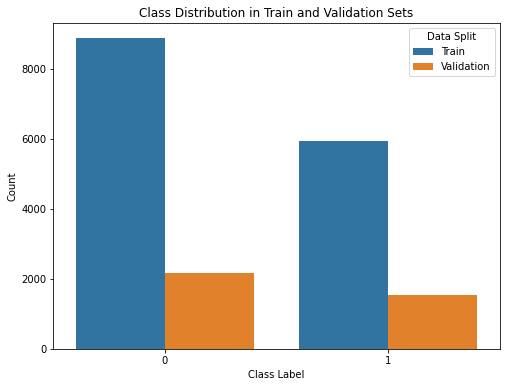

Number of data points with 'generated' label equal to 1 in Train set: 8869

Number of data points with 'generated' label equal to 1 in Validation set: 2163

Number of data points with 'generated' label equal to 1 in Train set: 5943

Number of data points with 'generated' label equal to 1 in Validation set: 1540


In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

# 클래스 분포 확인을 위한 데이터프레임 생성
train_df = pd.DataFrame({"Data Split": ["Train"] * len(train_labels), "Labels": train_labels})
validation_df = pd.DataFrame({"Data Split": ["Validation"] * len(validation_labels), "Labels": validation_labels})
combined_df = pd.concat([train_df, validation_df])

# 카운트 플롯 그리기
plt.figure(figsize=(8, 6))
sns.countplot(data=combined_df, x="Labels", hue="Data Split")
plt.title("Class Distribution in Train and Validation Sets")
plt.xlabel("Class Label")
plt.ylabel("Count")
plt.legend(title="Data Split")
plt.show()


# Train set에서 0의 개수 세기
train_generated_1_count = train_df[train_df["Labels"] == 0].shape[0]
print("Number of data points with 'generated' label equal to 1 in Train set:", train_generated_1_count)

# Validation set에서 0의 개수 세기
validation_generated_1_count = validation_df[validation_df["Labels"] == 0].shape[0]
print("Number of data points with 'generated' label equal to 1 in Validation set:", validation_generated_1_count)

# Train set에서 1의 개수 세기
train_generated_1_count = train_df[train_df["Labels"] == 1].shape[0]
print("Number of data points with 'generated' label equal to 1 in Train set:", train_generated_1_count)

# Validation set에서 1의 개수 세기
validation_generated_1_count = validation_df[validation_df["Labels"] == 1].shape[0]
print("Number of data points with 'generated' label equal to 1 in Validation set:", validation_generated_1_count)


In [28]:
# 데이터셋 준비
train_inputs = {
    "input_ids": np.array(train_inputs["input_ids"].to_list()),
    "attention_mask": np.array(train_inputs["attention_mask"].to_list())
}
train_labels = np.array(train_labels)

validation_inputs = {
    "input_ids": np.array(validation_inputs["input_ids"].to_list()),
    "attention_mask": np.array(validation_inputs["attention_mask"].to_list())
}
validation_labels = np.array(validation_labels)

print("train_inputs shape:", train_inputs["input_ids"].shape)
print("validation_inputs shape:", validation_inputs["input_ids"].shape)
print("train_labels shape:", train_labels.shape)
print("validation_labels shape:", validation_labels.shape)

train_inputs shape: (14812, 256)

validation_inputs shape: (3703, 256)

train_labels shape: (14812,)

validation_labels shape: (3703,)


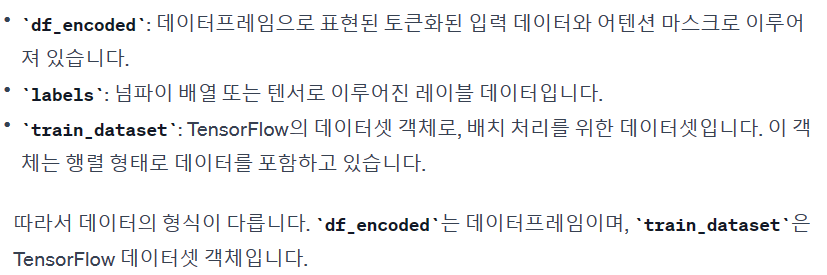

In [29]:
# 모델 컴파일
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5, epsilon=1e-08)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [30]:
# 입력 데이터 형상 확인
print("train_inputs[input_ids] shape:", train_inputs['input_ids'].shape)
print("train_inputs[attention_mask] shape:", train_inputs['attention_mask'].shape)
print("validation_inputs[input_ids] shape:", validation_inputs['input_ids'].shape)
print("validation_inputs[attention_mask] shape:", validation_inputs['attention_mask'].shape)

# 필요한 경우 패딩 또는 트리밍 수행
# 예시: train_inputs['input_ids'] = pad_or_trim(train_inputs['input_ids'], desired_length)

# 모델 학습을 다시 시도


train_inputs[input_ids] shape: (14812, 256)

train_inputs[attention_mask] shape: (14812, 256)

validation_inputs[input_ids] shape: (3703, 256)

validation_inputs[attention_mask] shape: (3703, 256)


In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

# 배치 크기 설정
batch_size = 8

# 체크포인트 파일 경로 설정
checkpoint_path = "best_model"

# ModelCheckpoint 콜백 생성 (Tensorflow SavedModel 형식으로 저장)
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min', save_format='tf')

# EarlyStopping 콜백 생성
early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1, mode='min')

# 모델 학습을 다시 시도하면서 콜백 추가
history = model.fit(
    train_inputs,
    train_labels,
    epochs=50,  # 에포크 수 증가
    batch_size=batch_size,
    validation_data=(validation_inputs, validation_labels),
    callbacks=[checkpoint, early_stopping]  # 콜백 리스트에 ModelCheckpoint와 EarlyStopping 추가
)


Epoch 1/30

1852/1852 [==============================] - ETA: 0s - loss: 0.0862 - accuracy: 0.9698

Epoch 00001: val_loss improved from inf to 0.03133, saving model to best_model


2024-01-16 03:57:59.967710: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.



INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets


1852/1852 [==============================] - 780s 413ms/step - loss: 0.0862 - accuracy: 0.9698 - val_loss: 0.0313 - val_accuracy: 0.9914

Epoch 2/30

1852/1852 [==============================] - ETA: 0s - loss: 0.0352 - accuracy: 0.9910

Epoch 00002: val_loss did not improve from 0.03133

1852/1852 [==============================] - 734s 397ms/step - loss: 0.0352 - accuracy: 0.9910 - val_loss: 0.0367 - val_accuracy: 0.9873

Epoch 3/30

1852/1852 [==============================] - ETA: 0s - loss: 0.0213 - accuracy: 0.9945

Epoch 00003: val_loss did not improve from 0.03133

1852/1852 [==============================] - 732s 395ms/step - loss: 0.0213 - accuracy: 0.9945 - val_loss: 0.1179 - val_accuracy: 0.9600

Epoch 4/30

1852/1852 [==============================] - ETA: 0s - loss: 0.0168 - accuracy: 0.9954

Epoch 00004: val_loss improved from 0.03133 to 0.03115, saving model to best_model


INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets


1852/1852 [==============================] - 762s 412ms/step - loss: 0.0168 - accuracy: 0.9954 - val_loss: 0.0311 - val_accuracy: 0.9889

Epoch 5/30

1852/1852 [==============================] - ETA: 0s - loss: 0.0201 - accuracy: 0.9942

Epoch 00005: val_loss did not improve from 0.03115

1852/1852 [==============================] - 735s 397ms/step - loss: 0.0201 - accuracy: 0.9942 - val_loss: 0.0966 - val_accuracy: 0.9622

Epoch 6/30

1852/1852 [==============================] - ETA: 0s - loss: 0.0108 - accuracy: 0.9968

Epoch 00006: val_loss did not improve from 0.03115

1852/1852 [==============================] - 735s 397ms/step - loss: 0.0108 - accuracy: 0.9968 - val_loss: 0.1608 - val_accuracy: 0.9741

Epoch 7/30

1852/1852 [==============================] - ETA: 0s - loss: 0.0101 - accuracy: 0.9972

Epoch 00007: val_loss did not improve from 0.03115

1852/1852 [==============================] - 734s 397ms/step - loss: 0.0101 - accuracy: 0.9972 - val_loss: 0.0339 - val_accuracy: 

In [ ]:
import matplotlib.pyplot as plt

# 정확도 그래프
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# 손실 그래프
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.show()


In [ ]:
from sklearn.metrics import roc_curve, auc

# 검증 데이터에 대한 예측 로짓을 얻음
y_pred_logits = model.predict(validation_inputs).logits

# 로짓을 확률로 변환 (이진 분류 가정)
y_pred_probs = tf.nn.softmax(y_pred_logits, axis=1)[:, 1].numpy()

# ROC 곡선 계산
fpr, tpr, thresholds = roc_curve(validation_labels, y_pred_probs)

# AUC 계산
roc_auc = auc(fpr, tpr)

# ROC 곡선 그리기
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [ ]:
# y_pred_logits의 형태와 처음 몇 개의 로짓 출력
print("Shape of y_pred_logits:", y_pred_logits.shape)
print("Sample logits:", y_pred_logits[:5])

# y_pred_probs의 형태와 처음 몇 개의 확률 출력
print("Shape of y_pred_probs:", y_pred_probs.shape)
print("Sample probabilities:", y_pred_probs[:5])

# ======test set에 대한 검증=======

In [ ]:
# 저장된 모델의 경로
saved_model_path = "best_model"  # .h5 확장자 제거

# 저장된 모델 불러오기
loaded_model = tf.keras.models.load_model(saved_model_path)

In [ ]:
# test_essays 데이터의 토큰화 진행 상황을 표시
test_input_ids = []
test_attention_masks = []

for text in tqdm(test_essays['text'].tolist(), desc="토큰화 진행중"):
    encoded = tokenizer.encode_plus(text, 
                                    add_special_tokens=True, 
                                    max_length=256, 
                                    padding='max_length', 
                                    truncation=True, 
                                    return_attention_mask=True, 
                                    return_tensors='np')
    test_input_ids.append(encoded['input_ids'][0])
    test_attention_masks.append(encoded['attention_mask'][0])



test_inputs = {
    "input_ids": np.array(test_input_ids),
    "attention_mask": np.array(test_attention_masks)
}  
print("test_inputs shape:", test_inputs["input_ids"].shape)

In [ ]:
# 검증 데이터에 대한 예측 로짓을 얻음
prediction_logits = loaded_model.predict(test_inputs).logits

# 예측 결과를 적절한 형태로 변환
prediction_probs = tf.nn.softmax(prediction_logits, axis=1)[:, 1].numpy()

# 결과를 캐글 제출 형식에 맞게 데이터프레임으로 변환
submission = pd.DataFrame({
    'id': test_essays['id'],  # 샘플 ID
    'prediction': prediction_probs  # 예측 확률
})

# 결과를 CSV 파일로 저장
submission.to_csv('submission.csv', index=False)
